In [1]:
import torch
import numpy as np
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

print("imports successful!")

imports successful!


In [2]:
y_train = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-classification/Data/train/labels.pt")
y_test = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-classification/Data/test/labels.pt")

/state/partition1/job-54630429/ipykernel_668262/2292649188.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  y_train = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-

In [2]:
x_train = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-classification/Data/train/train_rep.pt")
x_test = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-classification/Data/test/test_rep.pt")

/state/partition1/job-54572618/ipykernel_985906/2255235829.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-

In [3]:
x_train_layer1 = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-classification/Data/train/train_representations_firstlayer.pt")
x_test_layer1 = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-classification/Data/test/test_representations_firstlayer.pt")

/state/partition1/job-54630429/ipykernel_668262/2760535100.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train_layer1 = torch.load("/scratch/as20482/ML_Final_Proj/Au

In [3]:
x_train_layer3 = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-classification/Data/train/train_representations_thirdlayer.pt")
x_test_layer3 = torch.load("/scratch/as20482/ML_Final_Proj/AudioSet-classification/Data/test/test_representations_thirdlayer.pt")

/state/partition1/job-54624160/ipykernel_1656829/4105970534.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_train_layer3 = torch.load("/scratch/as20482/ML_Final_Proj/A

In [4]:
def calculate_map(y_true, y_pred):
    n_classes = y_true.shape[1]
    average_precisions = []
    for i in range(n_classes):
        y_true_class = y_true[:, i]
        y_pred_class = y_pred[:, i]
        ap = average_precision_score(y_true_class, y_pred_class)
        average_precisions.append(ap)
    average_precisions_sorted = sorted(average_precisions, reverse=True)
    print("\nTop 5 class-wise Average Precisions:")
    for i, ap in enumerate(average_precisions_sorted[:5]):
        print(f"Class {i+1}: {ap:.4f}")
    
    return np.mean(average_precisions)

In [5]:
def train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs=10, device='cuda'):
    print("Model being trained: ", model.__class__.__name__)
    model = model.to(device)
    model.train()
    loss_list = []
    for epoch in tqdm(range(num_epochs)):
        # Training phase
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
        loss_list.append(train_loss/len(train_loader))
    return model, loss_list

In [6]:
def test_model(model, test_loader, device='cuda'):
    print("Model being tested: ", model.__class__.__name__)
    
    model.eval()
    
    test_predictions = []
    test_targets = []
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x = batch_x.to(device)
            outputs = model(batch_x)
            test_predictions.extend(outputs.cpu().numpy())
            test_targets.extend(batch_y.cpu().numpy())
    
    test_predictions = np.array(test_predictions)
    test_targets = np.array(test_targets)
    
    test_map = calculate_map(test_targets, test_predictions)
    test_f1 = f1_score(test_targets, (test_predictions > 0.5).astype(float), average="micro")
    
    print(f"Test MAP: {test_map:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")
    
    return test_map, test_f1

In [14]:
batch_size = 256
num_epochs = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
train_dataset = TensorDataset(x_train, y_train.float())
test_dataset = TensorDataset(x_test, y_test.float())
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [8]:
train_dataset_layer1 = TensorDataset(x_train_layer1, y_train.float())
train_loader_layer1 = DataLoader(train_dataset_layer1, batch_size=batch_size, shuffle=True)
test_dataset_layer1 = TensorDataset(x_test_layer1, y_test.float())
test_loader_layer1 = DataLoader(test_dataset_layer1, batch_size=32, shuffle=False)

In [8]:
train_dataset_layer3 = TensorDataset(x_train_layer3, y_train.float())
train_loader_layer3 = DataLoader(train_dataset_layer3, batch_size=batch_size, shuffle=True)
test_dataset_layer3 = TensorDataset(x_test_layer3, y_test.float())
test_loader_layer3 = DataLoader(test_dataset_layer3, batch_size=32, shuffle=False)

# RNN

In [ ]:
class RNNClassifier(nn.Module):
    def __init__(self, input_size=768, hidden_size=1024, num_layers=2, num_classes=527, dropout=0.1):
        super(RNNClassifier, self).__init__()
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )
        
    def forward(self, x):
        rnn_output, hidden = self.rnn(x)
        pooled_output = torch.mean(rnn_output, dim=1)
        output = self.fc(pooled_output)
        return output

In [46]:
model = RNNClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [47]:
model, loss_list = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  RNNClassifier


100%|██████████| 35/35 [21:14<00:00, 36.42s/it]


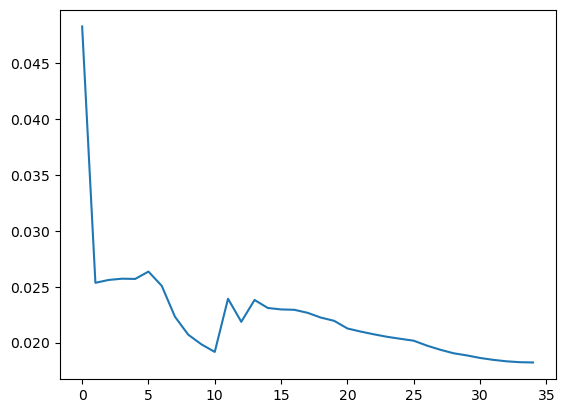

In [48]:
plt.plot(loss_list)

In [49]:
test_model(model, test_loader)

Model being tested:  RNNClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.7683
Class 2: 0.5870
Class 3: 0.5759
Class 4: 0.5617
Class 5: 0.5161
Test MAP: 0.0700
Test F1-Score: 0.1210


(np.float64(0.0700444367620246), np.float64(0.12101361834166523))

In [9]:
class RNNMaxClassifier(nn.Module):
    def __init__(self, input_size=768, hidden_size=1024, num_layers=2, num_classes=527, dropout=0.1):
        super(RNNMaxClassifier, self).__init__()
        
        self.rnn = nn.RNN(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )
        
    def forward(self, x):
        rnn_output, hidden = self.rnn(x)
        pooled_output, _ = torch.max(rnn_output, dim=1)
        output = self.fc(pooled_output)
        return output

In [9]:
model = RNNMaxClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [10]:
model, loss_list = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  RNNMaxClassifier


100%|██████████| 35/35 [58:04<00:00, 99.56s/it] 


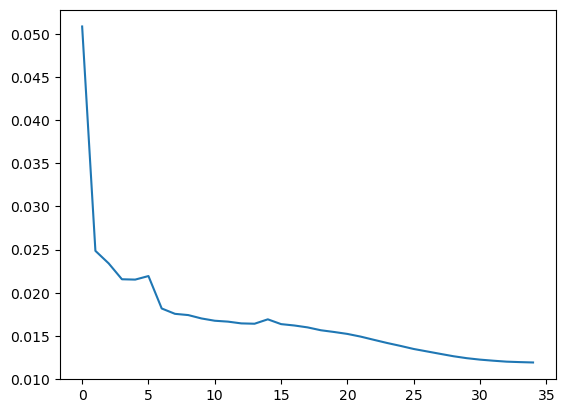

In [11]:
plt.plot(loss_list)

In [12]:
test_model(model, test_loader)

Model being tested:  RNNMaxClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.7871
Class 2: 0.7002
Class 3: 0.6770
Class 4: 0.6404
Class 5: 0.6375
Test MAP: 0.1962
Test F1-Score: 0.2718


(np.float64(0.19617979210841444), np.float64(0.2717664312324056))

In [ ]:
model = RNNMaxClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader_layer1), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [ ]:
model, loss_list = train_model(model, train_loader_layer1, criterion, optimizer, scheduler, num_epochs, device)

In [ ]:
plt.plot(loss_list)

In [14]:
test_model(model, test_loader_layer1)

Model being tested:  RNNMaxClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.4595
Class 2: 0.3002
Class 3: 0.1013
Class 4: 0.0650
Class 5: 0.0592
Test MAP: 0.0107
Test F1-Score: 0.0000


(np.float64(0.010748397030296094), np.float64(0.0))

In [11]:
model = RNNMaxClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader_layer3), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [13]:
model, loss_list = train_model(model, train_loader_layer3, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  RNNMaxClassifier


100%|██████████| 35/35 [1:09:48<00:00, 119.67s/it]


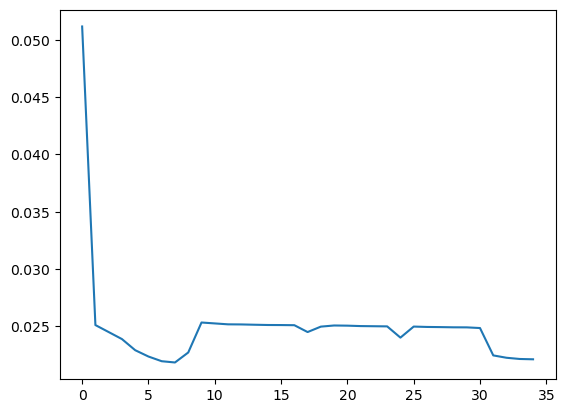

In [14]:
plt.plot(loss_list)

In [15]:
test_model(model, test_loader_layer3)

Model being tested:  RNNMaxClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.6227
Class 2: 0.3729
Class 3: 0.1951
Class 4: 0.0941
Class 5: 0.0816
Test MAP: 0.0166
Test F1-Score: 0.0720


(np.float64(0.01660484557256491), np.float64(0.07199984279510306))

# GRU

In [10]:
class GRUClassifier(nn.Module):
    def __init__(self, input_size=768, hidden_size=1024, num_layers=2, num_classes=527, dropout=0.1):
        super(GRUClassifier, self).__init__()
        
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )
        
    def forward(self, x):
        rnn_output, hidden = self.rnn(x)
        pooled_output = torch.mean(rnn_output, dim=1)
        output = self.fc(pooled_output)
        return output

In [53]:
model = GRUClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [54]:
model, loss_list = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  GRUClassifier


100%|██████████| 35/35 [27:59<00:00, 47.97s/it]


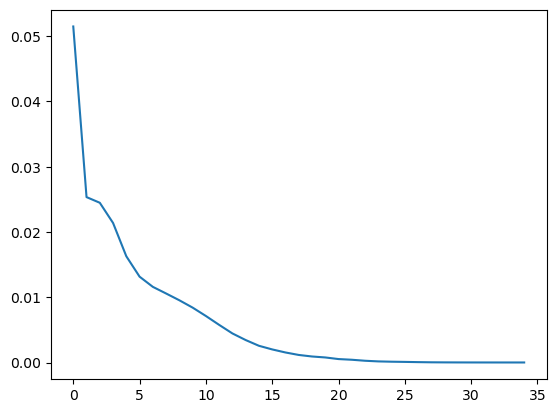

In [55]:
plt.plot(loss_list)

In [56]:
test_model(model, test_loader)

Model being tested:  GRUClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.9208
Class 2: 0.9056
Class 3: 0.8988
Class 4: 0.8980
Class 5: 0.8886
Test MAP: 0.3811
Test F1-Score: 0.5144


(np.float64(0.3810540087918704), np.float64(0.5143697264126822))

In [13]:
class GRUMaxClassifier(nn.Module):
    def __init__(self, input_size=768, hidden_size=1024, num_layers=2, num_classes=527, dropout=0.1):
        super(GRUMaxClassifier, self).__init__()
        
        self.rnn = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )
        
    def forward(self, x):
        rnn_output, hidden = self.rnn(x)
        pooled_output, _ = torch.max(rnn_output, dim=1)
        output = self.fc(pooled_output)
        return output

In [14]:
model = GRUMaxClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [15]:
model, loss_list = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  GRUMaxClassifier


100%|██████████| 35/35 [2:20:36<00:00, 241.04s/it]  


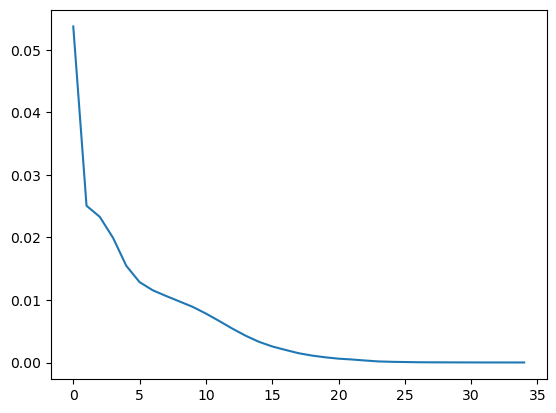

In [16]:
plt.plot(loss_list)

In [17]:
test_model(model, test_loader)

Model being tested:  GRUMaxClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.9253
Class 2: 0.9165
Class 3: 0.9133
Class 4: 0.9009
Class 5: 0.8950
Test MAP: 0.3843
Test F1-Score: 0.5122


(np.float64(0.38434802970733295), np.float64(0.5122286128814965))

In [16]:
model = GRUClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader_layer1), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [17]:
model, loss_list = train_model(model, train_loader_layer1, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  GRUClassifier


100%|██████████| 5/5 [15:14<00:00, 182.97s/it]


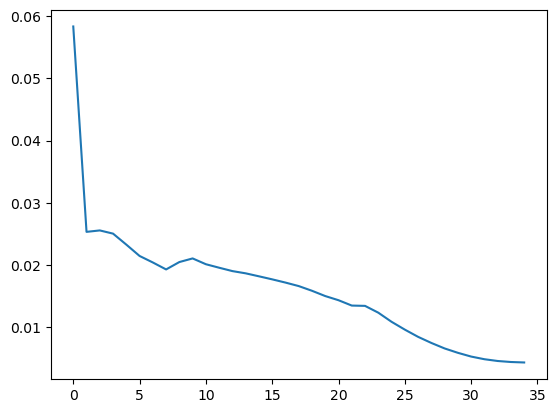

In [18]:
plt.plot(loss_list)

In [18]:
test_model(model, test_loader_layer1)

Model being tested:  GRUClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.4650
Class 2: 0.3438
Class 3: 0.0942
Class 4: 0.0826
Class 5: 0.0639
Test MAP: 0.0128
Test F1-Score: 0.0007


(np.float64(0.012812921004371881), np.float64(0.0006646864549363355))

In [10]:
model = GRUClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader_layer3), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [11]:
model, loss_list = train_model(model, train_loader_layer3, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  GRUClassifier


100%|██████████| 35/35 [1:47:05<00:00, 183.59s/it]


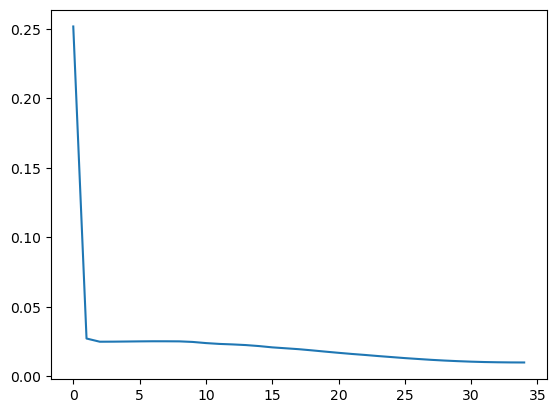

In [12]:
plt.plot(loss_list)

In [13]:
test_model(model, test_loader_layer3)

Model being tested:  GRUClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.7024
Class 2: 0.6280
Class 3: 0.5573
Class 4: 0.4952
Class 5: 0.4471
Test MAP: 0.1150
Test F1-Score: 0.2552


(np.float64(0.11504716496412469), np.float64(0.25522233030517866))

# LSTM

In [9]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=768, hidden_size=1024, num_layers=2, num_classes=527, dropout=0.1):
        super(LSTMClassifier, self).__init__()
        
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )
        
        self.fc = nn.Sequential(
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )
        
    def forward(self, x):
        rnn_output, hidden = self.rnn(x)
        pooled_output = torch.mean(rnn_output, dim=1)
        output = self.fc(pooled_output)
        return output

In [58]:
model = LSTMClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [59]:
model, loss_list = train_model(model, train_loader, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  LSTMClassifier


100%|██████████| 35/35 [28:08<00:00, 48.24s/it]


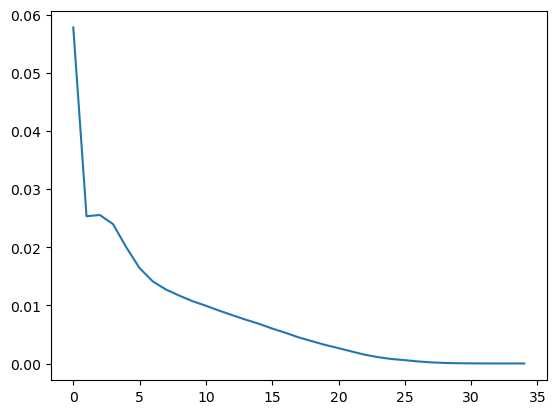

In [60]:
plt.plot(loss_list)

In [61]:
test_model(model, test_loader)

Model being tested:  LSTMClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.9067
Class 2: 0.8927
Class 3: 0.8696
Class 4: 0.8686
Class 5: 0.8500
Test MAP: 0.3573
Test F1-Score: 0.5023


(np.float64(0.35728219380515325), np.float64(0.5023387843258253))

In [15]:
model = LSTMClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader_layer1), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [16]:
model, loss_list = train_model(model, train_loader_layer1, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  LSTMClassifier


100%|██████████| 2/2 [08:55<00:00, 267.62s/it]


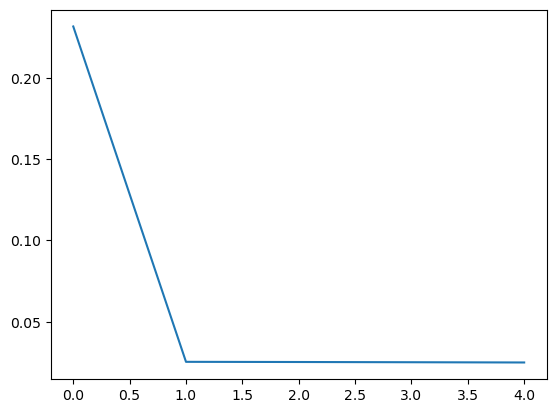

In [12]:
plt.plot(loss_list)

In [17]:
test_model(model, test_loader_layer1)

Model being tested:  LSTMClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.3483
Class 2: 0.2707
Class 3: 0.0481
Class 4: 0.0294
Class 5: 0.0293
Test MAP: 0.0061
Test F1-Score: 0.0000


(np.float64(0.006094962939511908), np.float64(0.0))

In [10]:
model = LSTMClassifier()
optimizer = torch.optim.AdamW(model.parameters(), lr = 1e-5, betas=(0.9, 0.999), weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader_layer3), epochs=num_epochs)

criterion = nn.BCEWithLogitsLoss()

In [11]:
model, loss_list = train_model(model, train_loader_layer3, criterion, optimizer, scheduler, num_epochs, device)

Model being trained:  LSTMClassifier


100%|██████████| 35/35 [2:16:01<00:00, 233.20s/it]  


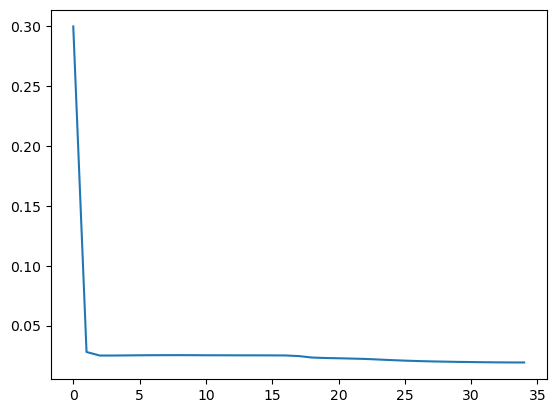

In [12]:
plt.plot(loss_list)

In [13]:
test_model(model, test_loader_layer3)

Model being tested:  LSTMClassifier

Top 5 class-wise Average Precisions:
Class 1: 0.7459
Class 2: 0.5564
Class 3: 0.3390
Class 4: 0.3092
Class 5: 0.2922
Test MAP: 0.0508
Test F1-Score: 0.1292


(np.float64(0.05079352063241875), np.float64(0.12921561197423267))